# Neural network

In this notebook we will see how tensor trains can be used to replace linear layers
in neural networks. As we will see this can lead to high compression rates for fully
connected layer.

In [1]:
from typing import Generator
from copy import deepcopy
from collections import deque
import time

import torch as tr
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader

from trainsum.torch import trainsum as ts
from trainsum.typing import TrainShape, EinsumExpression, TensorTrain
import matplotlib.pyplot as plt

In [2]:
# create the datasets and data loaders
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

train_dataset = tv.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = tv.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

First we load a MNIST dataset (hand written numbers from 0 to 9) and save it in the
folder ./data. The set is divided into a training set (train_loader) and testing set (test_loader).

In [3]:
class LinearLayerNN(nn.Module):
    """Simple neural network, which has three linear layer connected via relu activation funktions."""
    def __init__(self, size: int):
        super(LinearLayerNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(28*28, size)
        self.fc2 = nn.Linear(size, size)
        self.fc3 = nn.Linear(size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Here we define the neural network that we will use to classify the numbers. We have three fully connected layer,
that are combined with the ReLu activation function.

In [4]:
def training(train_loader: DataLoader, model: nn.Module, epochs: int) -> Generator[float]:
    """Start the training loop for some data loader and a model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    running_loss = deque()
    for epoch in range(epochs):
    
        for i, (inputs, labels) in enumerate(train_loader):
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            
            # Print statistics
            running_loss.append(loss.item())
            if len(running_loss) == 100:
                running_loss.popleft()
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}],", end="")
            print(f"Loss: {sum(running_loss)/len(running_loss):.4f}", end="\r", flush=True)
            yield loss.item()
            
        scheduler.step()
    print()
    
def eval_model(test_loader: DataLoader, model: nn.Module):
    """Evaluate the model against a training set and print the result accuracy."""
    model.eval()
    correct = 0
    total = 0
    
    t = time.time()
    with tr.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = tr.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    diff = time.time() - t
    
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set is {accuracy:.2f}% and took {diff:.2f}s')
    
def print_memory_savings(model: nn.Module, ref_model: nn.Module):
    """Print the memory savings of some model in respect to a reference model"""
    model_numel = sum(param.numel() for param in model.parameters())
    ref_model_numel = sum(param.numel() for param in ref_model.parameters())
    perc = model_numel / ref_model_numel * 100
    print(f"{100-perc:.0f}% memory savings in respect to the reference model")

The training is defined as a Generator object which returns the current loss at each step.
The eval_model function evaluates the accuracy of the model in respect to the test dataset.
The last function is a utility functions calculating the difference in the number of parameters
of two models.

In [5]:
from math import prod
class TrainLayer(nn.Module):
    """Tensor train layer as replacement for a Linear layer."""

    _train: TensorTrain
    _exprs: dict[int, tuple[TrainShape | EinsumExpression]]

    def __init__(self, data: tr.Tensor, max_rank: int) -> None:
        """Create a tensor train torch-layer by approximating data with a maximum rank."""
        super().__init__()
        self._exprs = {}

        # convert the full input matrix to a tensor train
        data = data.T
        shape = ts.trainshape(*data.shape, mode="block")
        with ts.variational(max_rank=max_rank, cutoff=1e-7, ncores=2, nsweeps=2):
            self._train = ts.tensortrain(shape, data)

        # attach the data of the tensor train cores as weights to the model
        self.weights = nn.ParameterList(nn.Parameter(core) for core in self._train.cores)

    def forward(self, data: tr.Tensor) -> tr.Tensor:
        """Apply the linear map defined by the tensor train to data."""
        # get rid of batch sizes 1
        data = data if data.shape[0] != 1 else data[0,:]

        # calculate the expression for the batch size if not present
        if data.shape[0] not in self._exprs:
            if len(data.shape) == 1:
                inp_dims = [self._train.tnshape.dims[0]]
            else:
                inp_dims = [ts.dimension([data.shape[0]]), self._train.shape.dims[0]]
            out_dims = [self._train.shape.dims[1]]
            inp_shape = ts.trainshape(*inp_dims, mode="full")
            out_shape = ts.trainshape(*out_dims, mode="block")
            with ts.exact(optimizer="random-greedy-128"):
                expr = ts.einsum_expression("ai,ij->aj", inp_shape, self._train.shape, result_shape=out_shape)
                self._exprs[data.shape[0]] = (inp_shape, expr)

        # create input without copying
        shape, expr = self._exprs[data.shape[0]]
        view = [1, *[d.base for dim in shape.dims for d in dim], 1]
        inp = ts.tensortrain(shape, [data.view(view)])

        # perform the mapping
        res = expr(inp, self._train)

        # convert the result to a tensor
        return res.to_tensor()

    def normalize(self, idx: int):
        self._train.normalize(idx)

Since trainsum is a rather low level API, it does not include neural network layers. Here is a simple
example how such a layer can be built. It is called TrainLayer and will upon initialization approximate
some given data variationally with some maximum rank. The cores of the train are then interpreted as 
trainable neural network parameters. The only function that a nn.Module needs is the forward function
that applies some operation to the data. In our case this is a linear map defined by the tensor train.
Since the result needs to be a vector (not a tensor train) and therefore has no ranks we perform the 
operation exact. We try to cache the einsum expression for improved performance.

In [6]:
def normalization_sweeping(layer: TrainLayer) -> Generator[None]:
    """
    Create a generator, which upen called normalizes the layer to a single core in a sweeping manner.
    The layer is altered so that only the normalized core is active.
    """
    length = len(layer.weights)
    for i in range(length):
        layer.weights[i].requires_grad = False
    last_idx = 0
    while True:
        for i in range(length-1):
            layer.weights[last_idx].requires_grad = False
            layer.normalize(i)
            layer.weights[i].requires_grad = True
            last_idx = i
            yield
        for i in range(1, length)[::-1]:
            layer.weights[last_idx].requires_grad = False
            layer.normalize(i)
            layer.weights[i].requires_grad = True
            last_idx = i
            yield

The normalization sweeping function brings the TrainLayer into a canonical format. The core that has been normalized onto 
is the only core with trainable parameters. The reason for this function is, that keeping all cores variable leads to a 
highly nonlinear behaviour, which might not be advantageous for the optimization (depends on the problem though).

In [7]:
# define the size of the linear layers
size = 2**8

#create the linear model
ref_model = LinearLayerNN(size)

# train the model
model_loss = []
train_gen = training(train_loader, ref_model, 2)
for loss in train_gen:
    model_loss.append(loss)
eval_model(test_loader, ref_model)

Epoch [2/2], Step [1875/1875],Loss: 0.0819
Accuracy on the test set is 97.64% and took 1.65s


After defining all layers we can start by training the normal neural network with a size of 256.

In [8]:
# create the tensorized model by approximating the first layer
tn_model = deepcopy(ref_model)
tn_model.fc1 = TrainLayer(ref_model.fc1.weight.data, 16)

# start the training
tn_model_loss = []
training_gen = training(train_loader, tn_model, 2)
norm_sweep = normalization_sweeping(tn_model.fc1)
while True:
    try:
        next(norm_sweep)
        tn_model_loss.append(next(training_gen))
    except StopIteration:
        break

print_memory_savings(tn_model, ref_model)
eval_model(test_loader, tn_model)

Epoch [2/2], Step [1875/1875],Loss: 0.1042
72% memory savings in respect to the reference model
Accuracy on the test set is 96.43% and took 2.29s


Using the pretrained model as input we can now approximate the first layer as a tensor train.
By using the training generator and the normalization sweeping we train the newly created compressed model.
In this example we get memory savings of 72% without a big loss of accuracy.

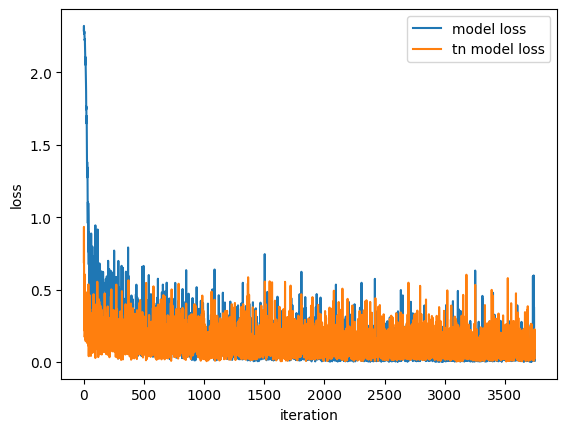

In [9]:
plt.figure()
plt.plot(model_loss, label="model loss")
plt.plot(tn_model_loss, label="tn model loss")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()